In [2]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd

In [3]:
#create nodes
G = nx.DiGraph()
nodes = open("Nodes.txt", 'r').read().split('\n')
lat = open("Latitude.txt", 'r').read().split('\n')
lon = open("Longitude.txt", 'r').read().split('\n')
airports = np.column_stack((nodes, lat, lon))

airports = airports[0:len(airports)-1,:]

for i in airports:
  G.add_node(i[0], pos = (i[1], i[2]))

In [4]:
len(list(G.nodes))

6072

([<matplotlib.axis.YTick at 0x7fde6b5a18e0>,
 <a list of 13 Text major ticklabel objects>)

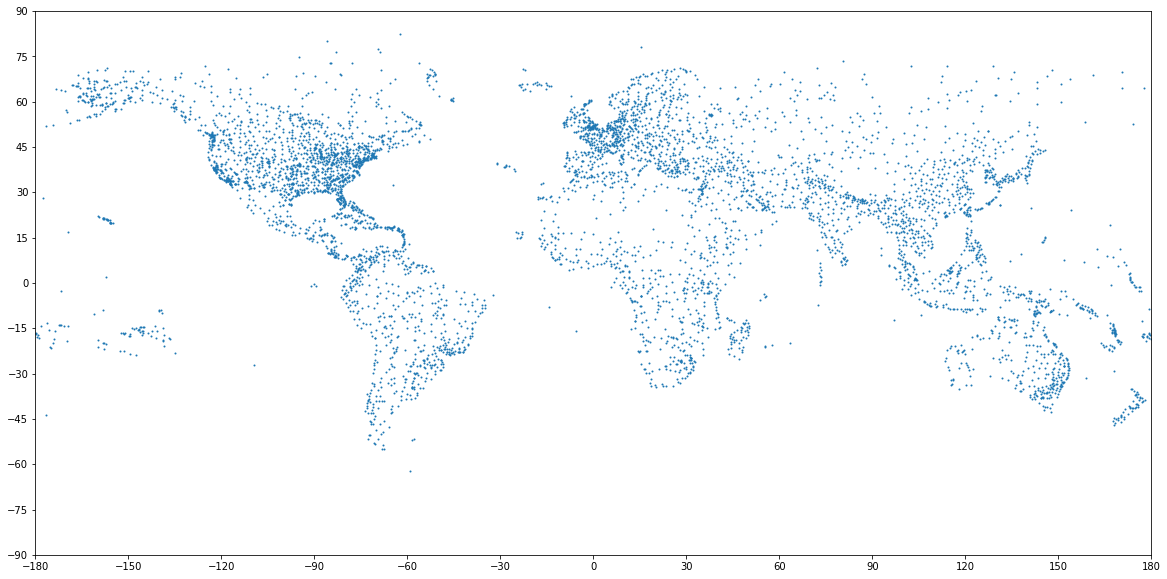

In [5]:
fig = plt.figure()
fig.set_size_inches(20, 10)
pos=nx.get_node_attributes(G,'pos')
for k, v in pos.items():
    pos[k] = (float(v[1]), float(v[0]))
nx.draw_networkx_nodes(G, pos, node_size = 1, label = False)
plt.xlim([-180, 180])
plt.ylim([-90, 90])
plt.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
plt.xticks(range(-180,181, 30))
plt.yticks(range(-90,91, 15))

In [35]:
sou = open("Source.txt", 'r').read().split('\n')
des = open("Destination.txt", 'r').read().split('\n')
routes = np.column_stack((sou, des))
print(len(routes))

67663


In [36]:
delete_list_sou = list(set(routes[:,0]) - set(airports[:,0]))

In [37]:
delete_list_des = list(set(routes[:,1]) - set(airports[:,0]))

In [38]:
print(delete_list_sou)

['KBU', 'BVV', 'QUB', 'SRK', 'CGA', 'DHB', 'FBS', 'KCQ', 'PUM', 'EXI', 'RKA', 'ORZ', 'SIC', 'SQS', 'XEQ', 'IUI', 'GRV', 'PPV', 'QJH', 'KLL', 'TQA', 'PEC', 'QUW', 'CXF', 'NTG', 'EDA', 'IKE', 'LMC', 'JUU', 'SAX', 'KKI', 'RDV', 'JJA', 'MRA', 'BNY', 'WWP', 'CKX', 'KOZ', 'MLH', 'TCD', 'OHH', 'TVS', 'ATT', 'AOQ', 'TZA', 'SSB', 'WNH', 'MNT', 'YKT', 'GCW', 'PYC', 'TQI', 'TCT', 'UGB', 'LSA', 'KCL', 'KXU', 'AOS', 'ACU', 'ZEL', 'PHO', 'TFI', 'DGA', 'KWF', 'KGQ', 'SAE', 'INC', 'SVC', 'OTD', 'PQS', 'BCV', 'LBP', 'QOQ', 'SVK', 'RCE', 'HYL', 'KAE', 'INB', 'QFN', 'NKI', 'EAR', 'SVS', 'SHC', 'KBC', 'FVM', 'GLN', 'IGM', 'MJU', 'SRV', 'WWT', 'SZI', 'SVR', 'ELL', 'BLD', 'SYB', 'KPB', 'OLH', 'ZDY', 'THD', 'CKD', 'GHE', 'TCR', 'KHQ', 'JUK', 'CZH', 'DIW', 'KCC', 'KUS', 'KTB', 'LKE', 'CUK', 'TGC', 'KGX', 'KUZ', 'BFQ', 'TNO', 'KKB', 'NUP', 'SGG', 'LNV', 'QUV', 'FDE', 'WSX', 'GNU', 'NSQ', 'TLT', 'OGM', 'LCR', 'IOQ', 'UPK', 'MCM', 'GSM', 'LGQ', 'FSZ', 'HKB', 'ORI', 'RIG', 'PND', 'PAF', 'SZE', 'PVE', 'RMP', 'TKE'

In [39]:
print(delete_list_des)

['KBU', 'BVV', 'QUB', 'SRK', 'CGA', 'DHB', 'FBS', 'KCQ', 'KZB', 'PUM', 'EXI', 'KPR', 'RKA', 'ORZ', 'SIC', 'SQS', 'XEQ', 'IUI', 'GRV', 'QJH', 'PPV', 'KLL', 'TQA', 'PEC', 'QUW', 'CXF', 'NTG', 'EDA', 'IKE', 'LMC', 'JUU', 'SAX', 'KKI', 'RDV', 'JJA', 'MRA', 'BNY', 'WWP', 'CKX', 'KOZ', 'MTE', 'MLH', 'TCD', 'OHH', 'TVS', 'ATT', 'AOQ', 'BSS', 'SSB', 'WNH', 'TZA', 'MNT', 'YKT', 'GCW', 'PYC', 'TQI', 'TCT', 'UGB', 'LSA', 'KCL', 'KXU', 'AOS', 'QFX', 'ACU', 'ZEL', 'PHO', 'TFI', 'DGA', 'KWF', 'KGQ', 'SAE', 'INC', 'SVC', 'OTD', 'PQS', 'BCV', 'LBP', 'QOQ', 'SVK', 'RCE', 'HYL', 'KAE', 'INB', 'QFN', 'NKI', 'EAR', 'SVS', 'SHC', 'KBC', 'FVM', 'GLN', 'IGM', 'MJU', 'SRV', 'WWT', 'SZI', 'SVR', 'ELL', 'BLD', 'SYB', 'KPB', 'OLH', 'ZDY', 'THD', 'CKD', 'GHE', 'TCR', 'KHQ', 'JUK', 'CZH', 'DIW', 'KCC', 'KUS', 'KTB', 'LKE', 'CUK', 'TGC', 'KGX', 'KUZ', 'BFQ', 'TNO', 'KKB', 'NUP', 'SGG', 'LNV', 'QUV', 'FDE', 'WSX', 'GNU', 'NSQ', 'TLT', 'OGM', 'LCR', 'IOQ', 'UPK', 'MCM', 'GSM', 'LGQ', 'FSZ', 'HKB', 'ORI', 'RIG', 'PND'

In [40]:
delete_list = []
for i in range(len(routes)):
  if routes[i][0] in delete_list_sou or routes[i][1] in delete_list_des:
    delete_list.append(i)
print(len(delete_list))

729


In [41]:
np.delete(routes, delete_list, 0)
print(len(routes))

67663


In [45]:
for i in routes:
  G.add_edge(i[0], i[1])

NetworkXError: ignored

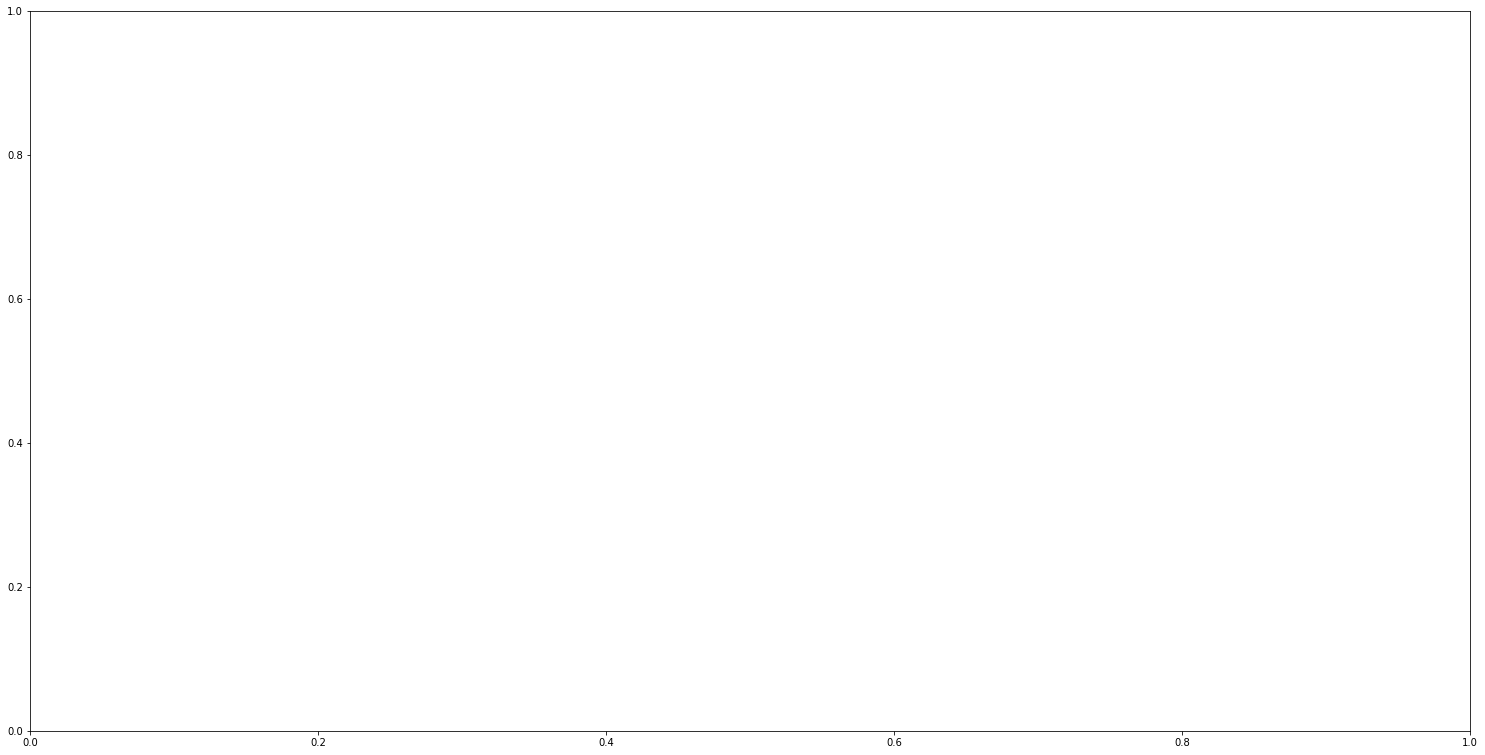

In [46]:
fig = plt.figure()
fig.set_size_inches(20, 10)
pos=nx.get_node_attributes(G,'pos')
for k, v in pos.items():
    pos[k] = (float(v[1]), float(v[0]))
nx.draw(G, pos, node_size = 1, label = False)
plt.xlim([-180, 180])
plt.ylim([-90, 90])
plt.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
plt.xticks(range(-180,181, 30))
plt.yticks(range(-90,91, 15))

In [ ]:
#create graph derectly from 'routes' because we have much less nodes than expected and it contains some typo in the attributes
G_a = nx.DiGraph()
with open('Source.txt') as f_s:
    lines_s = f_s.readlines()    
with open('Destination.txt') as f_d:
    lines_d = f_d.readlines()

In [ ]:
for i in range(0,len(lines_s)-1):
    G_a.add_edge(lines_s[i].rstrip(), lines_d[i].rstrip())

In [ ]:
G_a.number_of_edges()

37595

In [ ]:
len(list(G_a.nodes))

3425